# Frequency scaling

author: laquitainesteeve@gmail.com

Purpose: describe trace frequency scaling
 
Execution time: 3 min

Special hardware: on CPU, does not require GPU.

## Setup

Create, activate and select virtual environment kernel `demo` from (envs/demo.yml):

```bash
python -m ipykernel install --user --name demo --display-name "demo" # create kernel
```

In [8]:
%%time
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
from scipy.stats import kruskal
import scikit_posthocs as sp

print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath_evoked = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'
filepath_spont = 'sub-demo-npx-bio-spont/sub-demo-npx-bio-spont_ecephys.nwb'

# project path
#proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# enable spike bias import
sys.path.insert(0, proj_path)

from src.nodes.utils import get_config, demean
from src.nodes.validation import snr
from src.nodes.validation import amplitude, power_demo, power

# evoked demo
cfg_e, param_cfg_e = get_config("silico_neuropixels", "npx_evoked").values() # config
FREQ_MIN_E = param_cfg_e["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_E = param_cfg_e["run"]["preprocessing"]["max_filter_freq"]

# spontaneous demo
cfg_s, param_cfg_s = get_config("silico_neuropixels", "npx_spont").values() # config
FREQ_MIN_S = param_cfg_s["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_S = param_cfg_s["run"]["preprocessing"]["max_filter_freq"]

# layer parameter
lyrs = ["L5"]
prm = dict()
prm["SFREQ_NS"] = 40000  # sampling frequency
prm["SFREQ_NE"] = 20000

# plot parameters
FIG_SIZE = (1.5, 1.5)
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-06 12:14:41,336 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 12:14:41,373 - root - utils.py - get_config - INFO - Reading experiment config. - done
2025-04-06 12:14:41,377 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 12:14:41,401 - root - utils.py - get_config - INFO - Reading experiment config. - done
CPU times: user 139 ms, sys: 25.3 ms, total: 164 ms
Wall time: 1.04 s


### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 16
available gpus: False


['               total        used        free      shared  buff/cache   available',
 'Mem:           63497        2222       45949           3       16032       61275',
 'Swap:              0           0           0']

### Custom functions

In [3]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [4]:
%%time

# EVOKED DEMO

with DandiAPIClient() as client: # download the extractors from Dandi archive
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_evoked)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingE = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile") # get extractor
RecordingE = spre.astype(RecordingE, "int16") # compress to int16 (like kilosorts)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN_E, freq_max=FREQ_MAX_E)  # band-pass filter
RecordingE = spre.common_reference(RecordingE, reference="global", operator="median") # common reference
traces_ne = RecordingE.get_traces() # get trace array

# SPONTANEOUS DEMO

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_spont)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingS = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")
RecordingS = spre.astype(RecordingS, "int16")
RecordingS = spre.bandpass_filter(RecordingS, freq_min=FREQ_MIN_S, freq_max=FREQ_MAX_S)
RecordingS = spre.common_reference(RecordingS, reference="global", operator="median")
traces_ns = RecordingS.get_traces()

# report
print(RecordingE)
print(RecordingS)

CommonReferenceRecording: 120 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                          60.00s (1.00 minutes) - int16 dtype - 274.66 MiB
CommonReferenceRecording: 120 channels - 40.0kHz - 1 segments - 2,400,000 samples 
                          60.00s (1.00 minutes) - int16 dtype - 549.32 MiB
CPU times: user 37.6 s, sys: 5.89 s, total: 43.5 s
Wall time: 1min 12s


## Compute

In [6]:
%%time 

# Spontaneous
demeaned = demean(traces_ns) # remove the DC component by subtracting the means
psd_ns = power_demo.get_welch_psd_marques_silico_parallelized(demeaned) # calculate psd

# Evoked
demeaned = demean(traces_ne)
psd_ne = power_demo.get_welch_psd_ne_parallelized(demeaned)

# unit-test
assert psd_ns["freq"][1] == 1.0, "frequency resolution should be 1Hz"
assert psd_ne["freq"][1] == 1.0, "frequency resolution should be 1Hz"

CPU times: user 2.27 s, sys: 2.46 s, total: 4.74 s
Wall time: 9.55 s


## Plot per experiment across layers


LFP band
α=0.0±0.0
α=-0.0±0.0

Spiking band
α=-0.6±0.4
α=-0.6±0.3

 # sites
n=120 sites
n=120 sites

Power SNR
SNR: 14.682793050610968
SNR: 30.52403682662968


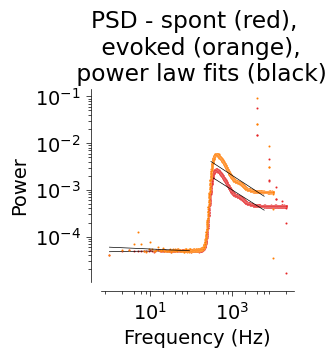

In [11]:
FIG_SIZE = (2.5,2.5)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7

fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# fitting
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2
)

# axes legend
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)

# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))
ax1.set_xlabel("Frequency (Hz)")    
ax1.set_ylabel("Power")    
plt.title("PSD - spont (red), \n evoked (orange),\n power law fits (black)")

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)

# report
print("\n # sites")
print(f"""n={psd_ns["power"].shape[0]} sites""")
print(f"""n={psd_ne["power"].shape[0]} sites""")

print("\nPower SNR")
out_ns = power.get_power_snr(psd_ns["power"], psd_ns["freq"], 300, 6000, 90)
out_ne = power.get_power_snr(psd_ne["power"], psd_ne["freq"], 300, 6000, 90)

## Plot per experiment per layer


LFP band
α=0.0±0.0
α=-0.0±0.0

Spiking band
α=-0.9±0.2
α=-0.9±0.2

Power SNR
SNR: 32.49256040090157
SNR: 50.36670250688456

LFP band
ns: α=0.0±0.0
ne: α=-0.0±0.0

Spiking band
ns: α=-0.3±0.1
ne: α=-0.3±0.2


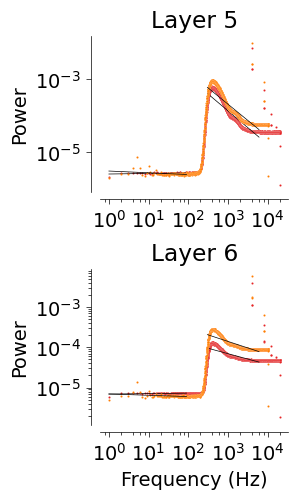

In [13]:
# parameters
FIG_SIZE = (3,5)

# compute
# layer 5
d5 = power.get_psd_data_prepro_layer_5_demo(
    "L5",
    psd_ns,
    psd_ne,
    RecordingS.get_property('layers'),
    RecordingE.get_property('layers'),
)

# layer 6
d6 = power.get_psd_data_prepro_demo(
    "L6",
    psd_ns,
    psd_ne,
    RecordingS.get_property('layers'),
    RecordingE.get_property('layers'),
)

# setup plpt
fig, axes = plt.subplots(2,1, figsize=FIG_SIZE)

# plot layer 5 and 6
axes[0], dd5 = power.plot_power_law_fits_layer_5_demo(axes[0], d5, prm, cl, pm, pm_fit1, pm_fit2)
axes[0].set_title('Layer 5')
axes[0].set_ylabel('Power')
axes[1], dd6 = power.plot_power_law_fits_demo(axes[1], d6, prm, cl, pm, pm_fit1, pm_fit2)
axes[1].set_title('Layer 6')
axes[1].set_ylabel('Power')
axes[1].set_xlabel('Frequency (Hz)')

# aesthetics
fig.tight_layout(**tight_layout_cfg)

## Plot frequency scaling slope in spiking band

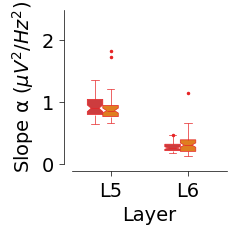

In [14]:
# parameters
FIG_SIZE = (2, 2)

# layer 5
df11 = get_slope_df(dd5["alphas_spiking_ns"], "NS", "L5")
df12 = get_slope_df(dd5["alphas_spiking_ne"], "NE", "L5")

# layer 6
df15 = get_slope_df(dd6["alphas_spiking_ns"], "NS", "L6")
df16 = get_slope_df(dd6["alphas_spiking_ne"], "NE", "L6")

# concatenate
plot_df_npx = pd.concat([df11,df12,df15,df16])

# setup plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot spiking band scaling
ax = sns.boxplot(
    ax=ax,
    data=plot_df_npx,
    x="Layer",
    y="Alpha",
    hue="Experiment",
    notch=True,
    hue_order=[
        "NS",
        "NE",
        "NB"],
    palette=[
        cl["COLOR_NS"],
        cl["COLOR_NE"],
    ],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylabel("Slope \u03B1 ($\u03bcV^2 /Hz^2$)")
ax.set_ylim([0, 2.5])

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NS"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NS"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NS"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1

## Hypothesis testing

In [15]:
def get_slope(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["Alpha"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L5 = {len(get_slope(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_slope(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L5", "L6"]
    df.index = ["L5", "L6"]
    return df


def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))


def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.Experiment==exp) & (plot_data.Layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

### Slope changes across layers?

Kruskal Wallis and posthoc

In [16]:
print("\n--------------------NS--------------------\n")
get_kk(plot_df_npx, "NS")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NS")
m_ns = get_medians_and_ci95(plot_df_npx, "NS", "Alpha")

print("\n--------------------E--------------------\n")
get_kk(plot_df_npx, "NE")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NE")
m_e = get_medians_and_ci95(plot_df_npx, "NE", "Alpha")


--------------------NS--------------------

H=87.6694214876033, p=7.73611874346834e-21
N_L5 = 52 sites
N_L6 = 68 sites
0.8972 $\pm$ 0.046358, 0.2519 $\pm$ 0.017421, 

--------------------E--------------------

H=82.97371078119738, p=8.315193738872084e-20
N_L5 = 52 sites
N_L6 = 68 sites
0.8597 $\pm$ 0.058935, 0.2994 $\pm$ 0.040215, 


## Are models the same?

In [17]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_power(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["Alpha"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_power(df, "NS", layer),
        get_power(df, "NE", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_E = {count_sites(df, "NE", layer)} sites""")
    print(f"""N_M = {count_sites(df, "MS", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "NE", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["NS", "NE"]
    df.index = ["NS", "NE"]
    return df


def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "NS", layer),
        get_power(plot_data, "NE", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["NS", "NE"]
    df.index = ["NS", "NE"]
    return df

In [18]:
print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_npx, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_npx, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_npx, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_npx, "L6"))


------LAYER 5:------

H=1.9902366863905172, p=0.15831613391284596
N_E = 52 sites
N_M = 0 sites


,NS,NE
NS,1.000000,0.158316
NE,0.158316,1.000000



------LAYER 6:------

H=2.6213724648296193, p=0.10543321261514006
N_E = 68 sites
N_M = 0 sites


,NS,NE
NS,1.000000,0.105433
NE,0.105433,1.000000
